[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/

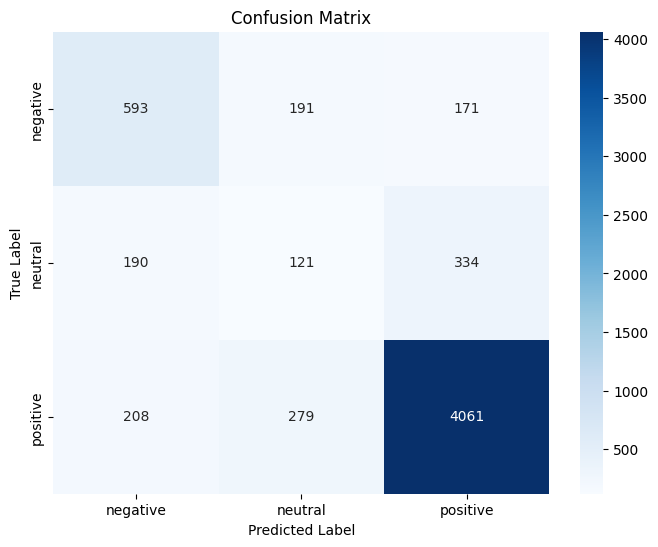

In [6]:
import numpy as np
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if (rating == 1) or (rating == 2):
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Print total sentiment in train and test set
print("\nTotal sentiment in train set:")
print(train_labels.value_counts())

print("\nTotal sentiment in test set:")
print(test_labels.value_counts())

# Tokenization and padding
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert to tensor
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM Model with dropout
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embeds = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(embeds, (h0, c0))
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)
        return output

# Parameters
vocab_size = max_words
embedding_dim = 300
hidden_size = 128
output_size = len(label_encoder.classes_)

# Create LSTM model instance
lstm_model = SentimentLSTM(vocab_size, embedding_dim, hidden_size, output_size, num_layers=2, dropout=0.3)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = lstm_model.to(device)

# Move class weights to the same device as the model
class_counts = Counter(y_train_smote)
total_samples = len(y_train_smote)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Training loop
def train_model(model, train_loader, optimizer, loss_fn, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return model

# Train the LSTM model
trained_lstm_model = train_model(lstm_model, train_loader, optimizer, loss_fn, num_epochs=10)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    return cm, cr

# Evaluate the LSTM model
conf_matrix, class_report = evaluate_model(trained_lstm_model, test_loader)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, label_encoder.classes_)
